In [ ]:

!pip install pandas numpy matplotlib seaborn scipy

!pip install scikit-learn shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fdc67351541df11e67ed2e63f7d2bb63d1c228c1633d4c091b5de59cb20547f4
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


Accuracy: 0.7471264367816092

Top features by mean |SHAP|:
      feature  mean_abs   std_abs  rank  relative_share
0  sex_female  0.114419  0.043536     1        0.216139
1    sex_male  0.109878  0.038690     2        0.207561
2         age  0.065445  0.064250     3        0.123627
3    pclass_3  0.051823  0.034793     4        0.097894
4        fare  0.049864  0.044993     5        0.094194
5    pclass_1  0.040427  0.029462     6        0.076368
6  embarked_C  0.024791  0.024892     7        0.046830
7       sibsp  0.024010  0.032962     8        0.045355
8       parch  0.019320  0.021848     9        0.036495
9    pclass_2  0.012483  0.010051    10        0.023580

Sensitive feature checks:
  sensitive                          related_cols  relative_share  min_rank  \
0       sex                [sex_female, sex_male]        0.423700         1   
1       age                                 [age]        0.123627         3   
2  embarked  [embarked_C, embarked_S, embarked_Q]        0.07

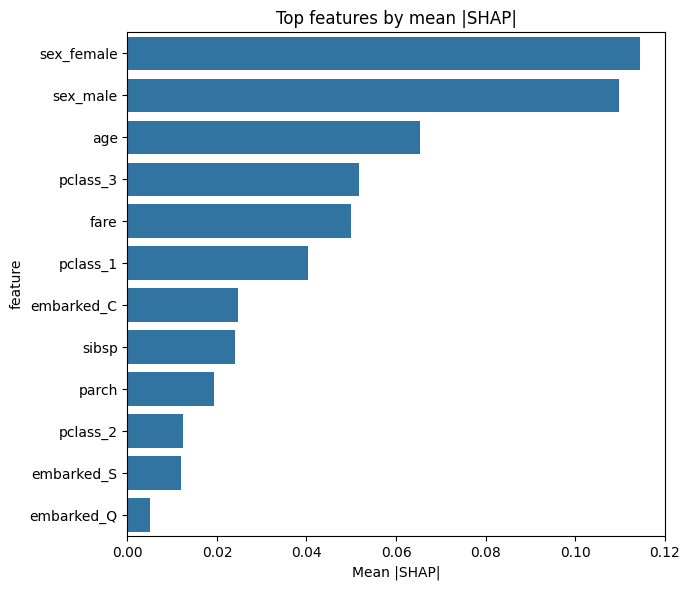

In [ ]:
# -----------------------------
# Name: Harsh Siddharth Brahmecha
# PRN: 20220802003
# -----------------------------

import openml
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

SENSITIVE = ['sex', 'age', 'embarked']
EPS = 0.05
TOPK = 5
SHAP_SAMPLE = 300

ds = openml.datasets.get_dataset(40945)
X_raw, y, _, _ = ds.get_data(target=ds.default_target_attribute, dataset_format='dataframe')
df = X_raw.copy()
df['survived'] = y
cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']
df = df[cols].dropna().reset_index(drop=True)

y = df['survived'].astype(int)
X = df.drop(columns=['survived'])
cat_cols = ['sex', 'embarked', 'pclass']
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=False)
feature_names = X_enc.columns.tolist()

X_train, X_test, y_train, y_test, X_train_orig, X_test_orig = train_test_split(
    X_enc, y, X, test_size=0.25, random_state=42, stratify=y
)

model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))

sample = X_test.sample(n=min(SHAP_SAMPLE, len(X_test)), random_state=42)
explainer = shap.TreeExplainer(model)
shap_out = explainer.shap_values(sample)

if isinstance(shap_out, list):
    shap_vals = shap_out[1] if len(shap_out) > 1 else shap_out[0]
elif isinstance(shap_out, np.ndarray):
    if shap_out.ndim == 3:
        idx = 1 if shap_out.shape[2] > 1 else 0
        shap_vals = shap_out[:, :, idx]
    elif shap_out.ndim == 2:
        shap_vals = shap_out
    else:
        raise ValueError("Unhandled SHAP shape: " + str(shap_out.shape))
else:
    raise ValueError("Unhandled SHAP return type")

shap_abs = pd.DataFrame(np.abs(shap_vals), columns=sample.columns, index=sample.index)

agg = pd.DataFrame({
    'feature': shap_abs.columns,
    'mean_abs': shap_abs.mean(axis=0),
    'std_abs': shap_abs.std(axis=0)
}).sort_values('mean_abs', ascending=False).reset_index(drop=True)
agg['rank'] = np.arange(1, len(agg) + 1)
agg['relative_share'] = agg['mean_abs'] / agg['mean_abs'].sum()

print("\nTop features by mean |SHAP|:")
print(agg.head(10))

flags = []
for s in SENSITIVE:
    related = [f for f in agg['feature'] if f.startswith(s + '_') or f == s]
    if not related and s in agg['feature'].values:
        related = [s]
    if not related:
        print(f" - Sensitive feature '{s}' not found (skipping).")
        continue
    mean_sum = agg.set_index('feature').loc[related, 'mean_abs'].sum()
    rel = mean_sum / agg['mean_abs'].sum()
    ranks = agg.set_index('feature').loc[related, 'rank']
    min_rank = int(ranks.min())
    flagged = (rel > EPS) or (min_rank <= TOPK)
    flags.append({'sensitive': s, 'related_cols': related, 'relative_share': rel, 'min_rank': min_rank, 'flagged': flagged})

print("\nSensitive feature checks:")
print(pd.DataFrame(flags))

def perturb_rows(orig_df, feature):
    dfp = orig_df.copy()
    if feature not in dfp.columns:
        return dfp
    if pd.api.types.is_numeric_dtype(dfp[feature].dtype):
        dfp[feature] = dfp[feature].median()
    else:
        vals = dfp[feature].dropna().unique().tolist()
        if len(vals) > 1:
            mode = dfp[feature].mode().iloc[0]
            alt = next((v for v in vals if v != mode), vals[0])
            dfp[feature] = alt
    return dfp

perturb_orig = X_test_orig.sample(n=min(200, len(X_test_orig)), random_state=42)
perturb_enc = X_test.loc[perturb_orig.index]
if hasattr(model, "predict_proba"):
    orig_probs = model.predict_proba(perturb_enc)[:, 1]
else:
    orig_probs = model.predict(perturb_enc)

perturb_stats = []
for s in SENSITIVE:
    if s not in X.columns:
        print(f"Skipping perturbation for '{s}' (not in original X columns).")
        continue
    pert = perturb_rows(perturb_orig, s)
    pert_enc = pd.get_dummies(pert, columns=cat_cols, drop_first=False).reindex(columns=feature_names, fill_value=0)
    if hasattr(model, "predict_proba"):
        pert_probs = model.predict_proba(pert_enc)[:, 1]
    else:
        pert_probs = model.predict(pert_enc)
    delta = np.abs(orig_probs - pert_probs)
    perturb_stats.append({'sensitive': s, 'mean_abs_delta': float(delta.mean())})

print("\nPerturbation results (mean absolute change in predicted prob):")
print(pd.DataFrame(perturb_stats))

plt.figure(figsize=(7, 6))
topn = min(15, len(agg))
sns.barplot(x='mean_abs', y='feature', data=agg.head(topn))
plt.title('Top features by mean |SHAP|')
plt.xlabel('Mean |SHAP|')
plt.tight_layout()
plt.show()